In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



In [36]:
datos_originales_conjunto_1 = pd.read_csv('X_modificado.csv', index_col=0)
datos_originales_conjunto_1

,Date,Price
0,1988-06-27,15.10
1,1988-06-28,15.27
2,1988-06-29,15.47
3,1988-06-30,14.85
4,1988-07-01,14.60
...,...,...
9139,2024-03-28,87.48
9140,2024-04-01,87.42
9141,2024-04-02,88.92
9142,2024-04-03,89.35


In [37]:
df = datos_originales_conjunto_1
# Convertir la columna 'fecha' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])




In [38]:
# las fechas están en desorden. Las ordenamos desde la "menor" fecha a la "mayor" (recordadndo que es DateTime)
df = df.sort_index()
# convertimos la columna 'Date' en el índice del DataFrame
df.set_index('Date', inplace=True)
df.dtypes

Price    float64
dtype: object

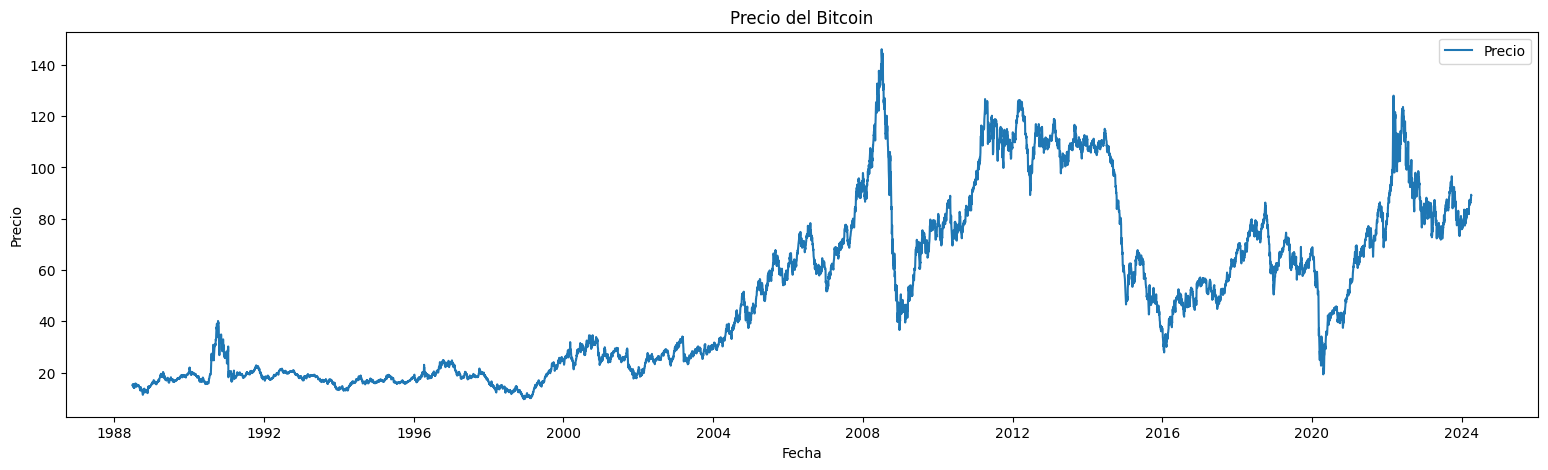

In [39]:
plt.figure(figsize=(19, 5))
plt.plot(df['Price'], label='Precio')
plt.title('Precio del Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

Error cuadrático medio (MSE): 59.32145659754255


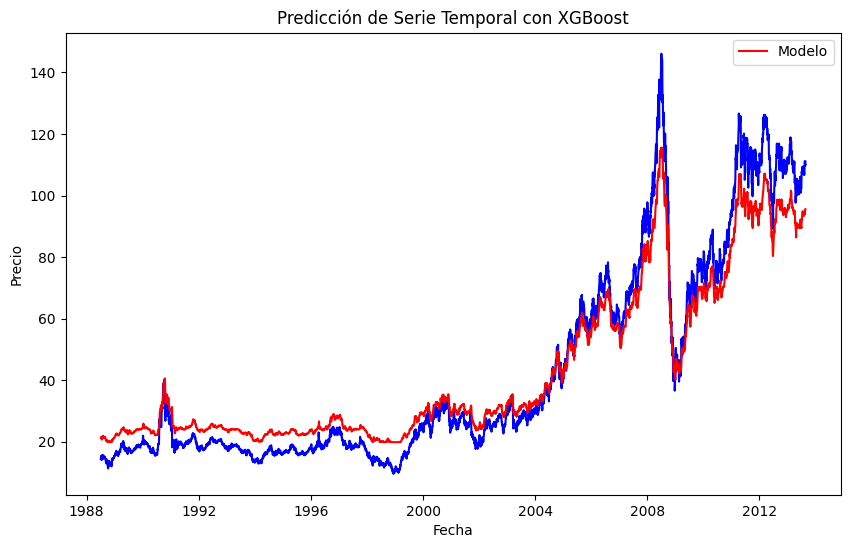

In [40]:
# Crear características de serie temporal (lag features)
def create_lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Price'].shift(lag)
    df = df.dropna()  # Eliminar filas con valores nulos
    return df

# Crear características de lag
df = create_lag_features(df, lags=5)

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Separar las características (X) y el target (y)
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1500, max_depth=4, learning_rate=0.001, colsample_bytree=0.3, reg_alpha=0.1, reg_lambda=0.1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Hacer predicciones
predictions = model.predict(X_train_scaled)

# Convertir las predicciones a un DataFrame
futuros = pd.DataFrame(predictions, index=train.index, columns=['Prediction'])


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_train, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(train.index, y_train, label='', color='blue')
plt.plot(train.index, predictions, label='Modelo', color='red')
plt.title('Predicción de Serie Temporal con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



In [41]:
df

,Price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
1988-07-04,14.35,14.60,14.85,15.47,15.27,15.10
1988-07-05,14.30,14.35,14.60,14.85,15.47,15.27
1988-07-06,14.68,14.30,14.35,14.60,14.85,15.47
1988-07-07,15.45,14.68,14.30,14.35,14.60,14.85
1988-07-08,15.05,15.45,14.68,14.30,14.35,14.60
...,...,...,...,...,...,...
2024-03-28,87.48,86.09,86.25,86.75,85.43,85.78
2024-04-01,87.42,87.48,86.09,86.25,86.75,85.43
2024-04-02,88.92,87.42,87.48,86.09,86.25,86.75


In [42]:
# Hacer que futuros cuente el index como una columna
futuros.reset_index(level=0, inplace=True)
futuros = futuros.rename(columns={'Prediction': 'Price'})
futuros

,Date,Price
0,1988-07-04,21.456341
1,1988-07-05,21.272745
2,1988-07-06,21.197815
3,1988-07-07,21.188950
4,1988-07-08,21.258369
...,...,...
6392,2013-08-19,95.098373
6393,2013-08-20,95.434616
6394,2013-08-21,95.434616
6395,2013-08-22,95.570190


In [43]:

import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
import shap


In [88]:
# Create forecaster
# ==============================================================================
end_validation = '2023-12-09'

window_features = RollingFeatures(stats=["coef_variation"], window_sizes=9000)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 5000,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:end_validation, 'Price'])
forecaster

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [   1    2    3 ... 4998 4999 5000] 
Window features: ['roll_coef_variation_9000'] 
Window size: 9000 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 9055] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': None, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': None, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None,
    'missing': nan, 'monotone_constraints': None, 'multi_strategy': None,
    'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None,
    'random_state': 15926, 'reg_alpha': None, 'reg_lambda': None,
    'sampling_method': None, 'scale_pos_weight': None, 'subsample': None,
    'tree_method': None, 'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2024-12-04 17:48:53 
Last fit date: 2024-12-04 17:49:01 
Skforecast version: 0.14.0 
Python version: 3.10.11 
Forecaster id: None

In [89]:
final = forecaster.predict(steps=365)
final


c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


9000    76.753738
9001    77.855957
9002    78.367935
9003    78.367935
9004    77.868011
          ...    
9360    83.383881
9361    83.383881
9362    82.798874
9363    82.798874
9364    82.798874
Name: pred, Length: 365, dtype: float64

### predicción 2 años

In [90]:
'''
graficar SOLAMENTE las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Futuro de la materia prima X')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()
'''
final_2_anios = forecaster.predict(steps=730)
final_2_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


9000    76.753738
9001    77.855957
9002    78.367935
9003    78.367935
9004    77.868011
          ...    
9725    88.205383
9726    88.205383
9727    88.205383
9728    88.205383
9729    88.205383
Name: pred, Length: 730, dtype: float64

In [91]:
final_3_anios = forecaster.predict(steps=1095)
final_3_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


9000     76.753738
9001     77.855957
9002     78.367935
9003     78.367935
9004     77.868011
           ...    
10090    79.521812
10091    79.339561
10092    79.521812
10093    79.521996
10094    79.521812
Name: pred, Length: 1095, dtype: float64

---

---